In [18]:
#用到的包
import numpy as np
import pandas as pd
import re
from gensim import corpora, models, similarities
import gensim
import pyLDAvis.gensim_models
import math
import matplotlib.pyplot as plt

In [19]:
"""第一步：用正则表达式清洗数据，并去除停用词"""
data=pd.read_csv(r"C:\Users\123\LDA\HillaryEmails.csv",encoding='ISO-8859-1')
# 原邮件数据中有很多Nan的值，直接扔了。
data=data[['Id','ExtractedBodyText']].dropna()  #只选取 Id和 ExtractedBodyText两列 去除空值 #只选取 Id和 ExtractedBodyText两列 去除空值

In [20]:
# 用正则表达式清洗数据

def clean_email_text(text):
    text= text.replace('\n'," ") #用空格代替新的行
    text=re.sub(r"-"," ",text)  #把用“-”连接的单词分开 （close-up分成close和 up）
    text=re.sub(r"\d+\d+\d+","",text) #删除日期
    text=re.sub(r"[0-2]?[1-9]:[0-6][0-9]","",text)  #删除时间
    text=re.sub(r"[\w]+@[\.\w]+","",text)  #删除邮件地址
    text=re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i","",text) #删除网址
    
    # 以防还有其他除了单词以外的特殊字符（数字）等等，我们把特殊字符过滤掉
    # 只留下字母和空格
    # 再把单个字母去掉，留下单词
    pure_text=''
    for letter in text:        #去除字母和空格
        letter=letter.lower()  #字母小写
        if letter.isalpha() or letter==' ':
            pure_text+=letter
            
    text=' '.join(word for word in pure_text.split() if len(word)>1)
    return text

In [21]:
docs=data['ExtractedBodyText']
print(docs)
docs=docs.apply(lambda s:clean_email_text(s))
docs.head(10).values

1        B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...
2                                                      Thx
4        H <hrod17@clintonemail.com>\nFriday, March 11,...
5        Pis print.\n-â?...-^\nH < hrod17@clintonernai...
7        H <hrod17@clintonemail.corn>\nFriday, March 11...
                               ...                        
22985    Hi. Sorry I haven't had a chance to see you, b...
22986    B6\nI assume you saw this by now -- if not, it...
22988    Big change of plans in the Senate. Senator Rei...
22990    PVerveer B6\nFriday, December 17, 2010 12:12 A...
22991                                           See below.
Name: ExtractedBodyText, Length: 6740, dtype: object


array(['thursday march pm latest how syria is aiding qaddafi and more sid hrc memo syria aiding libya docx hrc memo syria aiding libya docx march for hillary',
       'thx',
       'friday march pm huma abedin fw latest how syria is aiding qaddafi and more sid hrc memo syria aiding libya docx pis print',
       'pis print wednesday september pm fw meet the right wing extremist behind anti fvluslim film that sparked deadly riots from meat sent wednesday september pm to subject meet the right wing extremist behind anti muslim film that sparked deadly riots httemaxbiumenthalcommeet the right wing extremist behind anti musiim tihn that sparked deadly riots sent from my verizon wireless lte droid us department of state case no doc no date state dept produced to house select benghazi comm subject to agreement on sensitive information redactions no foia waiver state cb',
       'friday march pm huma abedin fw latest how syria is aiding qaddafi and more sid hrc memo syria aiding libya docx pis

In [22]:
doclist = docs.values#把值都取出来做成一个list
print("一共有",len(doclist),"封邮件。\n")
print("第一封邮件经过清洗后的内容为: \n",doclist[:1],'\n')

一共有 6740 封邮件。

第一封邮件经过清洗后的内容为: 
 ['thursday march pm latest how syria is aiding qaddafi and more sid hrc memo syria aiding libya docx hrc memo syria aiding libya docx march for hillary'] 



In [23]:
# 去除停用词，处理成gensim需要的输入格式
def remove_stopword():
    stopword = []
    with open(r'C:\Users\123\LDA\english.txt', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            line = line.replace('\n', '')
            stopword.append(line)
    return stopword
stop_words=remove_stopword()
texts=[[word for word in doc.lower().split() if word not in stop_words] for doc in doclist]
print("第一封邮件去除停用词并处理成gensim需要的格式为：\n",texts[0],'\n')

第一封邮件去除停用词并处理成gensim需要的格式为：
 ['march', 'syria', 'aiding', 'qaddafi', 'sid', 'hrc', 'memo', 'syria', 'aiding', 'libya', 'docx', 'hrc', 'memo', 'syria', 'aiding', 'libya', 'docx', 'march', 'hillary'] 



In [24]:
"""第二步：构建字典，将文本ID化"""
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
# 将每一篇邮件ID化
print("第一封邮件ID化后的结果为：\n",corpus[0],'\n')

第一封邮件ID化后的结果为：
 [(0, 3), (1, 2), (2, 1), (3, 2), (4, 2), (5, 2), (6, 2), (7, 1), (8, 1), (9, 3)] 



In [25]:
"""第三步：训练LDA模型"""
#LDA建模
LDA=gensim.models.ldamodel.LdaModel(corpus,id2word=dictionary,num_topics=3,random_state=100,
                chunksize=1000, passes=50,iterations=500)

In [26]:
#指定话题数和每个话题的词数（话题数用后面的困惑度和pyLDAvis来确定）
LDA.print_topics(num_topics=3,num_words=7)

[(0,
  '0.020*"office" + 0.016*"fyi" + 0.014*"secretarys" + 0.012*"meeting" + 0.007*"route" + 0.007*"arrive" + 0.006*"cheryl"'),
 (1,
  '0.007*"obama" + 0.006*"house" + 0.005*"president" + 0.005*"republican" + 0.004*"vote" + 0.004*"election" + 0.004*"democrats"'),
 (2,
  '0.005*"president" + 0.004*"government" + 0.004*"policy" + 0.004*"security" + 0.004*"obama" + 0.004*"israel" + 0.004*"women"')]

In [27]:
#用pyLDAvis来确定话题数
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LDA, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_1.html')#//将结果用HTML保存
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.093361  0.143956       1        1  56.029922
1     -0.127131 -0.129972       2        1  25.473092
0      0.220492 -0.013985       3        1  18.496986, topic_info=            Term        Freq       Total Category  logprob  loglift
868       office  885.000000  885.000000  Default  30.0000  30.0000
46           fyi  632.000000  632.000000  Default  29.0000  29.0000
273   secretarys  542.000000  542.000000  Default  28.0000  28.0000
864      meeting  603.000000  603.000000  Default  27.0000  27.0000
886        route  252.000000  252.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
880        press  148.403304  268.377163   Topic3  -5.5428   1.0951
583    secretary  193.317056  557.975303   Topic3  -5.2784   0.6276
344        staff  155.339972  319.839390   Topic3  -5.4971   0.9654
1060     release  121.245251  173.042800   Topic3  -5.7449   1.3318
29         house  145.643821  691.146231   Topic3  -5.5616   0.1304

[210 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
11         3  0.997177          abedin
916        1  0.921058  administration
916        2  0.076755  administration
2804       1  0.995533          afghan
58         1  0.998737     afghanistan
...      ...       ...             ...
23763      2  0.991479         wilders
2404       1  0.966974           women
2404       2  0.032700           women
8792       2  0.988992            worn
4311       3  0.985936     âdeclassify

[289 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [28]:
#困惑度计算
def perplexity(ldamodel, testset, dictionary, size_dictionary, num_topics):
    prep = 0.0
    prob_doc_sum = 0.0
    topic_word_list = [] 
    for topic_id in range(num_topics):
        topic_word = ldamodel.show_topic(topic_id, size_dictionary)
        dic = {}
        for word, probability in topic_word:
            dic[word] = probability
        topic_word_list.append(dic)
    doc_topics_ist = [] 
    for doc in testset:
        doc_topics_ist.append(ldamodel.get_document_topics(doc, minimum_probability=0))
    testset_word_num = 0
    for i in range(len(testset)):
        prob_doc = 0.0 
        doc = testset[i]
        doc_word_num = 0 
        for word_id, num in dict(doc).items():
            prob_word = 0.0 
            doc_word_num += num
            word = dictionary[word_id]
            for topic_id in range(num_topics):
                prob_topic = doc_topics_ist[i][topic_id][1]
                prob_topic_word = topic_word_list[topic_id][word]
                prob_word += prob_topic*prob_topic_word
            prob_doc += math.log(prob_word) 
        prob_doc_sum += prob_doc
        testset_word_num += doc_word_num
    prep = math.exp(-prob_doc_sum/testset_word_num)
    return prep

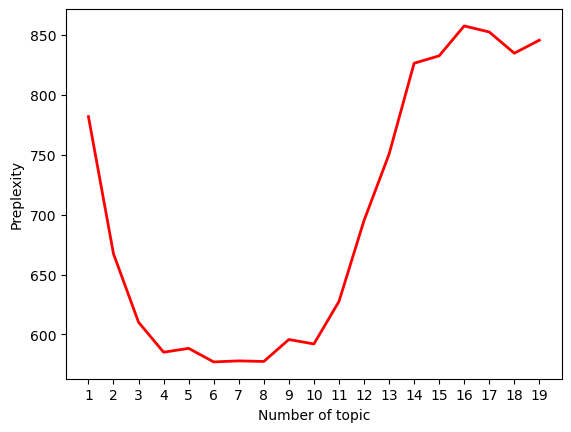

In [29]:
#topic个数hepreplexity的关系图（通过曲线的下降速度来确定合适的topic数）
topic=[]
prep_value=[]

for i in range(1,20,1): #话题数从1到20
    topic.append(str(i))
    ldamodel=gensim.models.ldamodel.LdaModel(corpus,id2word=dictionary,num_topics=i,random_state=100,
               chunksize=1000, passes=50,iterations=100)
    testset=[]
    num_topics=i
    for j in range(int(6740/20)):
        testset.append(corpus[j*20])
    dictionary=corpora.Dictionary(texts)
    size_dictionary=len(dictionary.keys())
    prep=perplexity(ldamodel, testset, dictionary,size_dictionary,num_topics)
    prep_value.append(prep)
    
plt.plot(topic,prep_value,linewidth=2,color="red")
plt.xlabel("Number of topic")
plt.ylabel("Preplexity")
#plt.savefig('./picture4-5.jpg', dpi=300)
plt.show()

In [30]:
"""第四步：查看某封邮件所属的主题"""
print("第一封邮件的大致内容为：\n",texts[0],'\n')
topic = LDA.get_document_topics(corpus[0])
print("第一封邮件的主题分布为：\n",topic,'\n')

第一封邮件的大致内容为：
 ['march', 'syria', 'aiding', 'qaddafi', 'sid', 'hrc', 'memo', 'syria', 'aiding', 'libya', 'docx', 'hrc', 'memo', 'syria', 'aiding', 'libya', 'docx', 'march', 'hillary'] 

第一封邮件的主题分布为：
 [(0, 0.964316), (1, 0.017149638), (2, 0.018534398)] 



In [31]:
# 希拉里发的两条推特
# 给大伙翻译一下这两句：
# 这是选举的一天!数以百万计的美国人投了希拉里的票。加入他们吧，确定你投给谁。
# 希望今天每个人都能度过一个安乐的感恩节，和家人朋友共度美好时光——来自希拉里的问候。
twitter = ["It's Election Day! Millions of Americans have cast their votes for Hillary—join them and confirm where you vote ",
       "Hoping everyone has a safe & Happy Thanksgiving today, & quality time with family & friends. -H"]

text_twitter = [clean_email_text(s) for s in twitter]
text_twitter = [[word for word in text.lower().split() if word not in stop_words] for text in text_twitter]
corpus_twitter = [dictionary.doc2bow(text) for text in text_twitter]
topics_twitter = LDA.get_document_topics(corpus_twitter)
print("这两条推特的主题分布分别为：\n",topics_twitter[0] ,'\n',topics_twitter[1])


这两条推特的主题分布分别为：
 [(0, 0.08871352), (1, 0.86773884), (2, 0.04354767)] 
 [(0, 0.6674384), (1, 0.28094873), (2, 0.05161285)]
